In [1]:
# Set project root
import os
import sys

# Manually set the path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from src.geometry import (
    compute_distance_from_homography,
    derive_metric_homography,
)
from src.matching import template_match
from src.measurement_data import load_measurements_from_yaml
from src.utils import load_calibration_json

## Analysis

In [3]:
# Load measurement data
data = load_measurements_from_yaml("../assets/measurements.yaml")

In [4]:
# Load camera calibration
K, dist_coeffs, image_size = load_calibration_json("../assets/camera_calibration.json")

In [5]:
scenes = data.get_all_scenes()

In [ ]:
def analyze_scene(scene_id, scenes, K):
    """
    This function analyzes a scene by executing the following steps:

    1. Load the scene and the corresponding templates.
    2. For each template, perform template matching against the scene image.
    3. Compute the homography and recover the camera pose.
    4. Compute the distance from the center of each template to the camera.
    5. Return the results including the template ID, homography, camera pose, and distance.
    """
    # Load scene and templates
    scene = data.get_scene(scene_id)
    templates = [data.get_template(t_id) for t_id in scenes[scene_id]]

    # Iterate over templates
    results = {}
    for template in templates:
        scene_path = os.path.join(project_root, scene.path)
        template_path = os.path.join(project_root, template.path)

        # Compute pixel-pixel homography
        H, mask, t_shape = template_match(template_path, scene_path, extract_method='SIFT', match_method='BF', plot=False)

        template_size_px = plt.imread(template_path).shape[:2]

        # Derive the metric-pixel homography
        H_metric = derive_metric_homography(
            H_px=H,
            template_size_px=template_size_px,
            template_size_metric=(template.height, template.width)
        )

        # Compute the condition number of the homography
        cond_num = np.linalg.cond(H_metric)

        # Template center point
        template_center_mm = np.array([template.width / 2, template.height / 2])

        # Compute the distance from the camera to the template center
        distance_pred = compute_distance_from_homography(
            H_mm2img=H_metric,
            K=K,
            point_mm=template_center_mm
        )

        # True distance and error
        distance_true = scene.get_distance('Camera', template.id).distance
        error = np.abs(distance_pred - distance_true)
        error_percent = (error / distance_true) * 100

        results[template.id] = {
            'homography': H.tolist(),
            'distance_pred': distance_pred,
            'distance_true': distance_true,
            'error': error,
            'error_percent': error_percent,
            'condition_number': cond_num
        }
    return results

In [7]:
def analyze_scenes(scenes, K):
    """
    Analyze all scenes and return results.
    """
    all_results = {}
    for scene_id in scenes:
        print(f"Analyzing scene {scene_id}...")
        results = analyze_scene(scene_id, scenes, K)
        all_results[scene_id] = results
    return all_results

In [8]:
results = analyze_scenes(scenes, K)

Analyzing scene S0...
Analyzing scene S1...
Analyzing scene S2...
Analyzing scene S3...
Analyzing scene S4...
Analyzing scene S5...
Analyzing scene S6...
Analyzing scene S7...
Analyzing scene S8...


In [9]:
results

{'S0': {'T1': {'homography': [[0.4034760726130916,
     -0.010496649023974833,
     404.4289962285276],
    [0.012195058510937285, 0.37581261192826376, 489.3970964334181],
    [2.1758948536551622e-05, -2.9522224189022333e-05, 1.0]],
   'distance_pred': np.float64(366.9624687200034),
   'distance_true': 390.0,
   'error': np.float64(23.037531279996585),
   'error_percent': np.float64(5.907059302563227),
   'condition_number': np.float64(165688.35786657463)}},
 'S1': {'T0': {'homography': [[0.1731142449573992,
     0.0036811935840644397,
     386.6823260893823],
    [-0.007340912157656944, 0.184200413397958, 620.4975077824822],
    [-1.2387107859510847e-05, 8.920604982593296e-06, 0.9999999999999999]],
   'distance_pred': np.float64(478.51962190660095),
   'distance_true': 490.0,
   'error': np.float64(11.480378093399054),
   'error_percent': np.float64(2.342934304775317),
   'condition_number': np.float64(286172.8602903675)}},
 'S2': {'T0': {'homography': [[0.3273087670565044,
     0.213

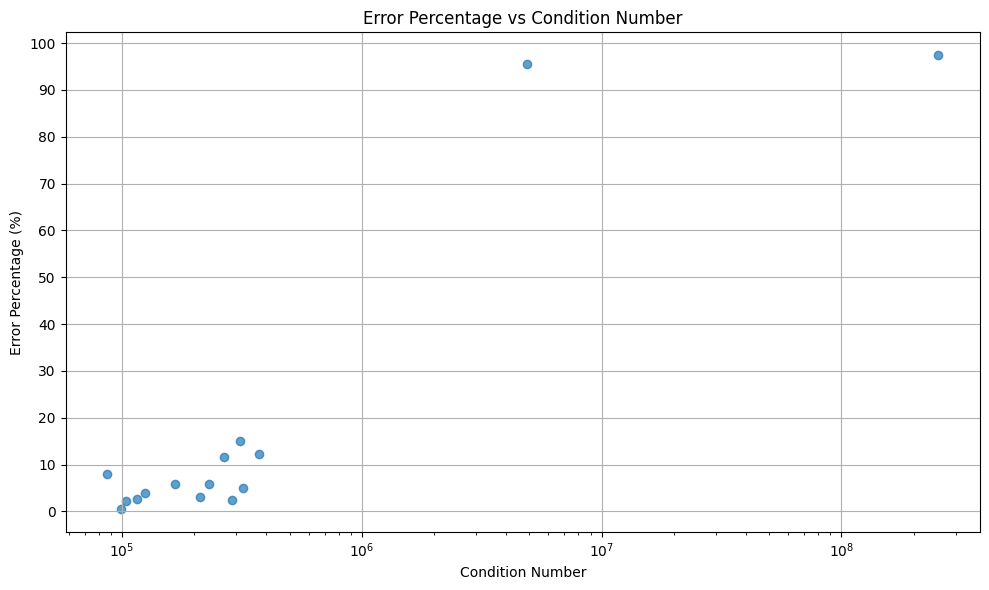

In [10]:
# Extract the error percentage and the condition number, and create a plot of the two against each other
error_percentages = []
condition_numbers = []
for scene_id, templates in results.items():
    for template_id, data in templates.items():
        error_percentages.append(data['error_percent'])
        condition_numbers.append(data['condition_number'])

plt.figure(figsize=(10, 6))
plt.scatter(condition_numbers, error_percentages, alpha=0.7)
plt.title('Error Percentage vs Condition Number')
plt.xlabel('Condition Number')
plt.ylabel('Error Percentage (%)')
plt.yticks(np.arange(0, 101, 10))
plt.xscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()